# spectrafit.py examples

The spectrafit module contains a set of functions used to identify peaks in experimental Raman spectra data. 

In [42]:
# import cell
import matplotlib.pyplot as plt
import pickle
from ramannoodles import spectrafit
from ramannoodles import shoyu

In [8]:
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys of compounds currently downloaded and stored in the library
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'N-PENTANE',
 'WATER']

## simple example

Utilizing the spectrafit module to conduct peak detection and least squares fitting is a simple as inputting the appropriate key from the `shoyu_data_dict` or experimental data into the wrapping functions `compound_report` or `data_report`, respectively.

In [17]:
library_compound = shoyu_data_dict['CARBON MONOXIDE']
fit_data = spectrafit.compound_report(library_compound)

The wrapper functions both return the same data: A list of peak center values, a list of peak sigmas (equal to 1/2 of the full width at half maximum), a list of peak amplitudes, the maximum cm$^{-1}$ value from the data and the minimum cm$^{-1}$ value from the data. The center, sigma, and amplitude values are determined using a least squares regression that fits a Lorentzian distribution to each detected peak.
  
For this simple example, the IR spectra for carbon monoxide was correctly identified as having two peaks. The values output from the wrapping function are as follows:

In [33]:
print('The center locations of the identified peaks = {}'.format(fit_data[0]))
print('The sigma values of the identified peaks = {}'.format(fit_data[1]))
print('The amplitues of the identified peaks = {}'.format(fit_data[2]))
print('The maximum cm\u207B\u00B9 value from the data = {}'.format(fit_data[3]))
print('The minimum cm\u207B\u00B9 value from the data = {}'.format(fit_data[4]))

The center locations of the identified peaks = [2109.8548231091986, 2183.5841650444086]
The sigma values of the identified peaks = [26.845569742021652, 21.035768826980632]
The amplitues of the identified peaks = [66.74326672969087, 51.65666941390134]
The maximum cm⁻¹ value from the data = 457.865
The minimum cm⁻¹ value from the data = 3803.38


## function examples
  
The following examples will demonstrate how the functions behind the spectrafit wrappers `compound_report` or `data_report` can be used. For most of these examples, the carbon monoxide spectra will be used to limit the processing time necessary to run this notebook on a personal computer.

#### spectrafit.subtract_baseline
This function relies primarily on the peakUtils.baseline.baseline function. This function however also includes an option to plot the results of the baseline identification and subtraction so that the user can visualize the result of the operation. For this example dimethyl ketone (acetone) was used since the NIST database spectra was not already baselined.

In [13]:
# extract spectra data
data = shoyu_data_dict['DIMETHYL KETONE']
x_data = data['x']
y_data = data['y']

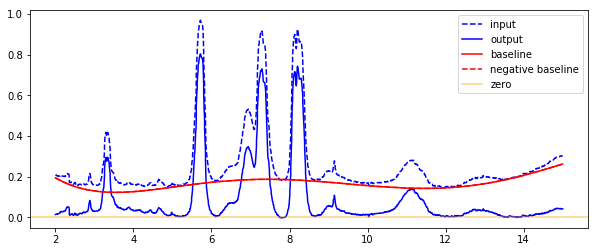

In [14]:
# subtract baseline
y_data = spectrafit.subtract_baseline(y_data, deg=5, plot=True, x_data=x_data)

When `plot=True`, this function not only returns the baseline subtracted y data, it also outputs a plot that shows the original input data, the output data, and the identified baseline.

#### spectrafit.peak_detect
This function relies primarily on the scipy.signal.find_peaks function. This function identifies peaks in the spectra data using a standard value for height, prominence, and distance. These values can be overwritted by the user if desired.

In [38]:
# extract spectra data
data = shoyu_data_dict['CARBON MONOXIDE']
x_data = data['x']
y_data = data['y']

In [39]:
# detect peaks
peaks, peak_list = spectrafit.peak_detect(x_data, y_data)

The first return is a list a tuples. Each tuple corresponds to a detected peak where the first value in the tuple is the position (wavenumber cm$^{-1}$) and the second is the height (counts) of the peak. 

In [44]:
peaks

[(2119.854823, 0.854), (2176.03476, 0.854)]

The second return contains the index positions of the detected peaks within the data, as well as a dictionary that contains arrays of the peak_heights, prominences, left_bases, and right_bases for each detected peak.

In [45]:
peak_list

(array([1775, 1835]),
 {'peak_heights': array([0.854, 0.854]),
  'prominences': array([0.855, 0.855]),
  'left_bases': array([794, 794]),
  'right_bases': array([3038, 3038])})

The following cell plots the detected peak locations as vertical orange bars atop the spectra data for carbon monoxide.

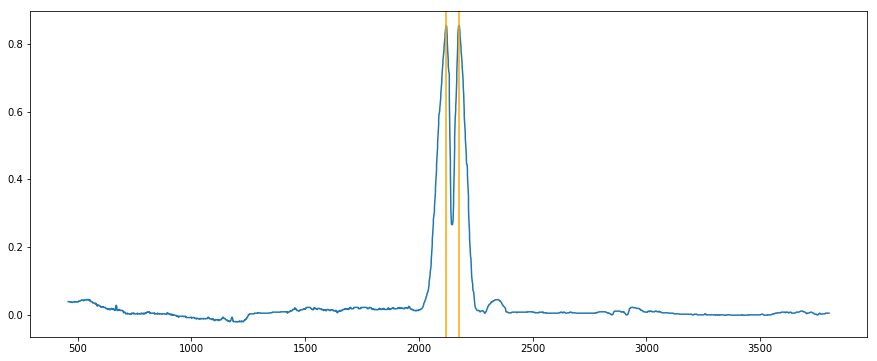

In [54]:
fig = plt.figure(figsize=(15,6))
plt.plot(x_data, y_data)
for i in peak_list[0]:
    plt.axvline(x=x_data[i], color='orange')

#### spectrafit.lorentz_params
After the locations of the peaks have been detected, they can be used as initial guesses for performing a least squares regression to fit the spectral data. This function inputs the detected peak height and position into a different Lorentizian model for each detected peak. The complete model therefore is a simple summation of these Lorentzian distributions.

In [55]:
# assign parameters for least squares fit
mod, pars = spectrafit.lorentz_params(peaks)

This function returns two objects: the lmfit.Model described above, and the list of parameters used to assign initial guesses and bounds to the least squares regression. 

In [56]:
mod

<lmfit.Model: (Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_'))>

In [57]:
pars

Parameters([('p1_sigma', <Parameter 'p1_sigma', 1.0, bounds=[0:500]>),
            ('p1_center',
             <Parameter 'p1_center', 2119.854823, bounds=[2109.854823:2129.854823]>),
            ('p1_amplitude', <Parameter 'p1_amplitude', 1.0, bounds=[0:inf]>),
            ('p1_fwhm',
             <Parameter 'p1_fwhm', 2.0, bounds=[-inf:inf], expr='2.0000000*p1_sigma'>),
            ('p1_height', <Parameter 'p1_height', 0.854, bounds=[0:1]>),
            ('p2_sigma', <Parameter 'p2_sigma', 1.0, bounds=[0:500]>),
            ('p2_center',
             <Parameter 'p2_center', 2176.03476, bounds=[2166.03476:2186.03476]>),
            ('p2_amplitude', <Parameter 'p2_amplitude', 1.0, bounds=[0:inf]>),
            ('p2_fwhm',
             <Parameter 'p2_fwhm', 2.0, bounds=[-inf:inf], expr='2.0000000*p2_sigma'>),
            ('p2_height', <Parameter 'p2_height', 0.854, bounds=[0:1]>)])

#### spectrafit.model_fit
This function utilizes the LMfit package to run a least squares regression. The optional report allows the user to see the LMfit report after running the regression. The function returns the standard output the the LMfit package. the `spectrafit.export_fit_data` function, described later, can be used to extract relevant information.

In [58]:
# fit the model to the data
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

[[Model]]
    (Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 3574
    # variables        = 8
    chi-square         = 2.20981072
    reduced chi-square = 6.1969e-04
    Akaike info crit   = -26390.6199
    Bayesian info crit = -26341.1684
[[Variables]]
    p1_sigma:      26.8784903 (init = 1)
    p1_center:     2109.85482 (init = 2119.855)
    p1_amplitude:  66.7644631 (init = 1)
    p1_fwhm:       53.7569806 == '2.0000000*p1_sigma'
    p1_height:     0.85400000 (init = 0.854)
    p2_sigma:      21.1897866 (init = 1)
    p2_center:     2183.63592 (init = 2176.035)
    p2_amplitude:  52.0596257 (init = 1)
    p2_fwhm:       42.3795733 == '2.0000000*p2_sigma'
    p2_height:     0.85400000 (init = 0.854)



#### spectrafit.plot_fit
This function allows the user to visualize the results of the least squares regression fit. This can he useful in trying to understand how the fit determines the parameters used to describe each peak's Lorentzian.

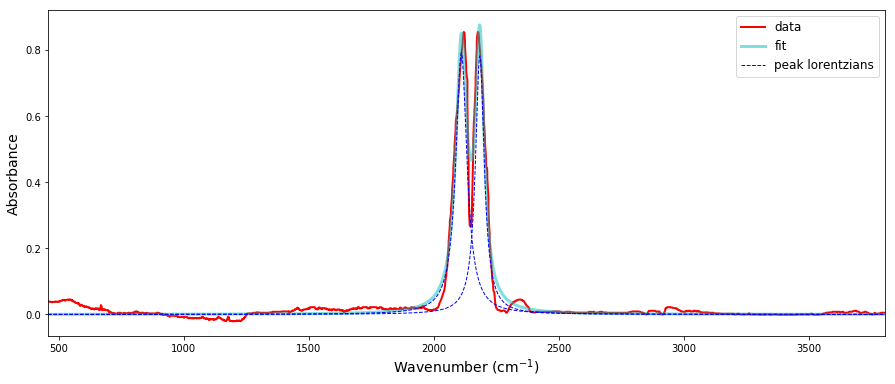

In [59]:
# plot fit results
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

#### spectrafit.export_fit_data
This function allows for the extraction of relevant parameters from the standard LMfit ouput. The return is a list containing values for each peak in separate arrays. Each array contains the sigma, center, amplitude, fwhm (full width at half maximum), and height for the relevant peak.

In [60]:
# export data in logical structure (see docstring)
fit_peak_data = spectrafit.export_fit_data(out)
fit_peak_data

[array([2.68784903e+01, 2.10985482e+03, 6.67644631e+01, 5.37569806e+01,
        8.54000000e-01]),
 array([2.11897866e+01, 2.18363592e+03, 5.20596257e+01, 4.23795733e+01,
        8.54000000e-01])]